In [1]:
from pathlib import Path

import graphviz
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics, model_selection, tree
from tqdm import tqdm

In [2]:
PATH = Path("results/prunned_tree")
PATH.mkdir(exist_ok=True)

In [3]:
df = pd.read_csv("data/final_train.csv", index_col=0)
df.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16",...,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,...,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,3.621984,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.071755,2.024442,3.0
3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,3.355701,...,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
4,LAYING,-1.548333,-0.139628,-2.380889,NaN,0.067613,-0.887342,6.007361,-11.970485,3.621984,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.102513,2.024442,3.0


# Data preprocessing

In [4]:
df = df.drop(columns=["subject", "void()"])
df = df.dropna()

In [5]:
y = df["Activity"]
X = df.drop(columns=["Activity"])

In [6]:
y.value_counts()

LAYING                1821
SITTING               1789
STANDING              1753
WALKING               1652
WALKING_UPSTAIRS      1369
WALKING_DOWNSTAIRS    1240
Name: Activity, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)

# Decision tree

In [8]:
tree_clf = tree.DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

# Full tree classification report

In [9]:
print("Test dataset accuracy:", tree_clf.score(X_test, y_test))

y_pred = tree_clf.predict(X_test)

print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Classification report:")
print(metrics.classification_report(y_test, y_pred))


Test dataset accuracy: 0.9559434746467166
Confusion matrix:
[[450   0   0   0   0   0]
 [  0 438  29   0   0   0]
 [  0  38 381   0   0   0]
 [  0   0   0 402   6  10]
 [  0   0   0   4 299   6]
 [  0   0   0   6   7 330]]
Classification report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       450
           SITTING       0.92      0.94      0.93       467
          STANDING       0.93      0.91      0.92       419
           WALKING       0.98      0.96      0.97       418
WALKING_DOWNSTAIRS       0.96      0.97      0.96       309
  WALKING_UPSTAIRS       0.95      0.96      0.96       343

          accuracy                           0.96      2406
         macro avg       0.96      0.96      0.96      2406
      weighted avg       0.96      0.96      0.96      2406



# Prunning tree

In [10]:
path = tree_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

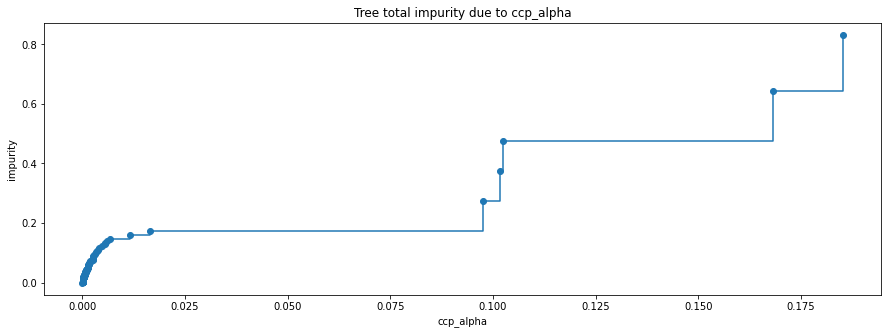

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
ax.set_title("Tree total impurity due to ccp_alpha")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("impurity")
plt.show()

In [12]:
clfs = [
    tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    for ccp_alpha in tqdm(ccp_alphas)
]

100%|██████████| 111/111 [05:42<00:00,  3.09s/it]


In [13]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

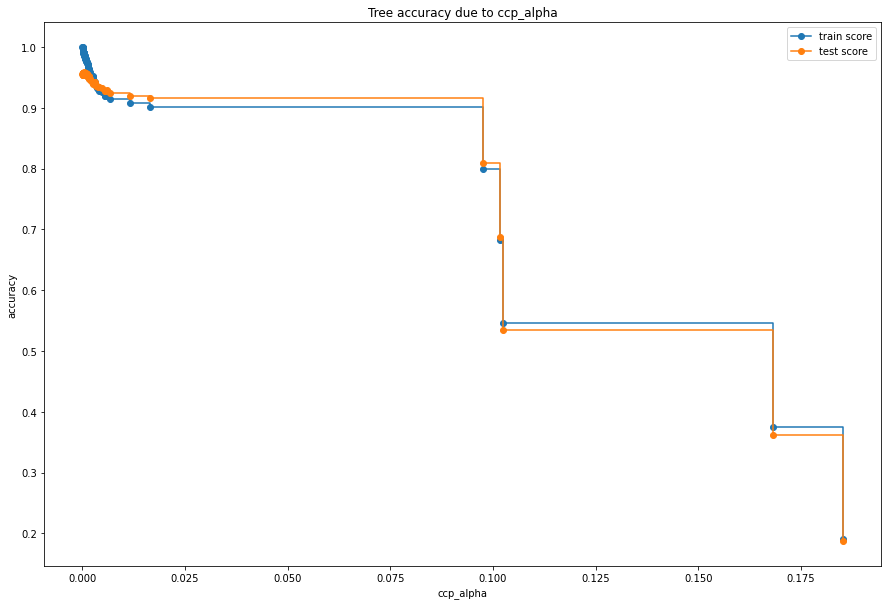

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(ccp_alphas, train_scores, marker='o', drawstyle="steps-post", label="train score")
ax.plot(ccp_alphas, test_scores, marker='o', drawstyle="steps-post", label="test score")
ax.set_title("Tree accuracy due to ccp_alpha")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("accuracy")
ax.legend()

plt.show()

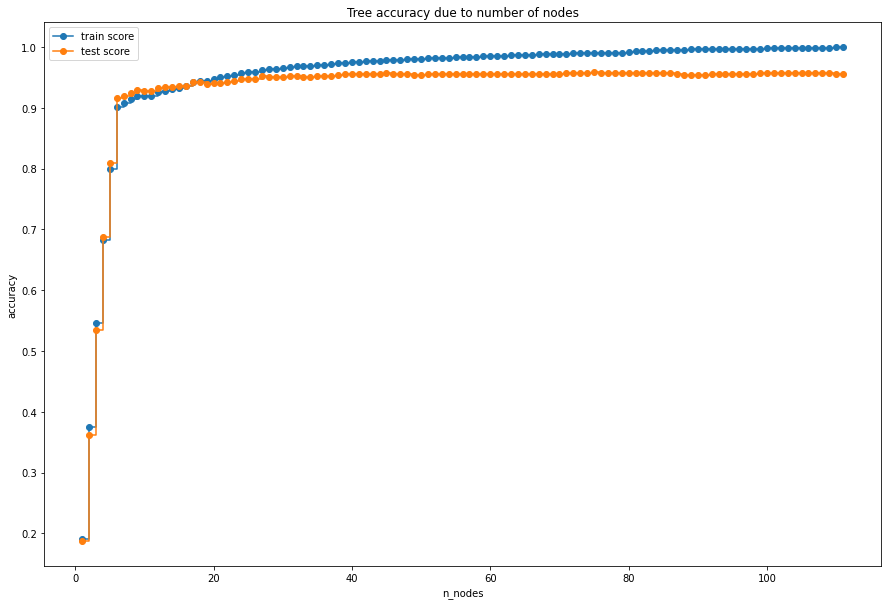

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(1 + np.arange(len(train_scores)), train_scores[::-1], marker='o', drawstyle="steps-post", label="train score")
ax.plot(1 + np.arange(len(test_scores)), test_scores[::-1], marker='o', drawstyle="steps-post", label="test score")

ax.set_title("Tree accuracy due to number of nodes")
ax.set_ylabel("accuracy")
ax.set_xlabel("n_nodes")
ax.legend()

plt.show()

# Prunned decision tree

In [16]:
selected_alpha = ccp_alphas[-6]
selected_alpha

prunned_tree_clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=selected_alpha)
prunned_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0165868593536087, random_state=42)

# Prunned tree classification insight

In [17]:
from functools import partial
print = partial(print, end=2*"\n")

print("Train dataset accuracy:", prunned_tree_clf.score(X_train, y_train))
print("Test dataset accuracy:", prunned_tree_clf.score(X_test, y_test))

y_pred = prunned_tree_clf.predict(X_test)
y_train_pred = prunned_tree_clf.predict(X_train)

print("Train dataset confusion matrix:")
print(metrics.confusion_matrix(y_train, y_train_pred))

print("Train dataset classification report:")
print(metrics.classification_report(y_train, y_train_pred))

print("Test dataset confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Test dataset classification report:")
print(metrics.classification_report(y_test, y_pred))

Train dataset accuracy: 0.901773344416736

Test dataset accuracy: 0.9164588528678305

Train dataset confusion matrix:

[[1371    0    0    0    0    0]
 [   0 1179  143    0    0    0]
 [   0  195 1139    0    0    0]
 [   0    0    0 1160   48   26]
 [   0    0    0   94  788   49]
 [   0    0    0  109   45  872]]

Train dataset classification report:

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00      1371
           SITTING       0.86      0.89      0.87      1322
          STANDING       0.89      0.85      0.87      1334
           WALKING       0.85      0.94      0.89      1234
WALKING_DOWNSTAIRS       0.89      0.85      0.87       931
  WALKING_UPSTAIRS       0.92      0.85      0.88      1026

          accuracy                           0.90      7218
         macro avg       0.90      0.90      0.90      7218
      weighted avg       0.90      0.90      0.90      7218


Test dataset confusion matrix:

[[450  

# Prunned tree visualisation

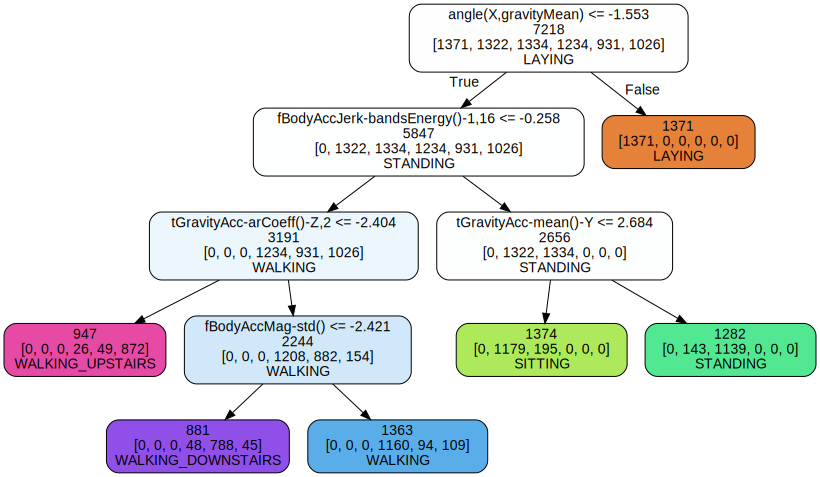

In [18]:
dot_data = tree.export_graphviz(
    prunned_tree_clf,
    feature_names=X.columns,
    class_names=prunned_tree_clf.classes_,
    label="none",
    filled=True,
    impurity=False,
    rounded=True
)
graph = graphviz.Source(dot_data)
graph.render("prunned_tree", directory=PATH, format="pdf")
graph

# Saving prunned tree

In [19]:
joblib.dump(prunned_tree_clf, PATH / "prunned_tree.joblib")

['results/prunned_tree/prunned_tree.joblib']